In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from PIL
import requests
import json
import open_clip
import torch
import os

# Define the path where the fashion dataset is stored
FASHION_DATASET_HOME = '/home/jcaldeira/dressing_virtuel_data_collector/media/images/'
#image = '0c0bfbde088d5b2f94f10b47f5b6352c28cbc148.jpg'
#image = '100_0144.JPG'
#image = '20150501_161427.jpg'
image = '100_0532.JPG'

# API endpoint to send requests
ENDPOINT = 'http://127.0.0.1:5000/dressing_virtuel'
ENDPOINT_CAT = 'http://127.0.0.1:5001/categorization_model'
ENDPOINT_SEG = 'http://127.0.0.1:5002/segmentation_model'

def get_categories(method, key):
    """
    Fetches categories (like gender, color, season, etc.) from the API.

    Args:
        method (str): API method to fetch (e.g., 'genders', 'colors').
        key (str): The key to extract from the API response (e.g., 'name', 'id').

    Returns:
        dict: A dictionary with category names as keys and their 
        corresponding IDs as values.
    """
    response = requests.get(f"{ENDPOINT}/{method}")
    dict = {x[key]: x['id'] for x in response.json()}

    return dict

def clip_evaluation(subcategories, image_path):
    json_post_image = {"path": image_path, "list_of_categories": subcategories}
    response = requests.get(f"{ENDPOINT_CAT}/fit_category", 
                            data = json.dumps(json_post_image))
    return response.json()

def clip_evaluation_dict(subcategories, image_path):
    json_post_image = {"path": image_path, "dict_of_categories": subcategories}
    response = requests.get(f"{ENDPOINT_CAT}/fit_categories", 
                            data = json.dumps(json_post_image))
    return response.json()

def seg_evaluation(image_path):
    json_post_image = {"path": image_path}
    response = requests.get(f"{ENDPOINT_SEG}/crop_single_clothes",
                            data = json.dumps(json_post_image))
    return response.json()

def seg_fullbody_evaluation(image_path):
    json_post_image = {"path": image_path}
    response = requests.get(f"{ENDPOINT_SEG}/crop_fullbody_clothes",
                            data = json.dumps(json_post_image))
    return response.json()


In [2]:
# Fetch categories from the API and store them in dictionaries
print('Getting Categories from Database ...')
dict_genders = get_categories('genders','gender')
dict_seasons = get_categories('seasons','name')
dict_colors = get_categories('colors','name')
dict_usage = get_categories('usage_types','name')
dict_article = get_categories('article_types','name')



Getting Categories from Database ...


In [3]:
# Loop through all images in the dataset
image_path = FASHION_DATASET_HOME + '/' + image

print('Executing the segmentation over the image...')
#new_image = seg_evaluation(image_path)
new_image = seg_fullbody_evaluation(image_path)
print(new_image)



Executing the segmentation over the image...
['/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727862019_qu73cq.png']


Extracting the categories from the cropped image ...


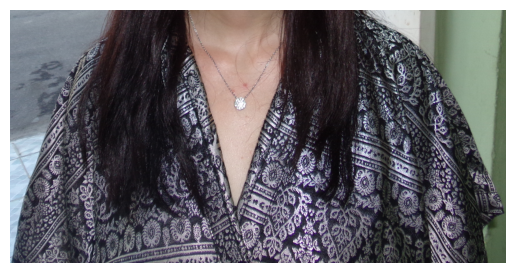

path: /home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727862019_qu73cq.png
{'gender': 'Unisex', 'season': 'Winter', 'color': 'Silver', 'usage': 'Ethnic', 'article': 'Robe'}


In [13]:
for image_path in new_image:
    print('Extracting the categories from the cropped image ...')
    dict_of_categories = {
        'gender': list(dict_genders.keys()),
        'season': list(dict_seasons.keys()),
        'color': list(dict_colors.keys()),
        'usage': list(dict_usage.keys()),
        'article': list(dict_article.keys())
    }
    # Perform CLIP evaluation to get the best matching category for each attribute
    selected_categories = clip_evaluation_dict(dict_of_categories,image_path)

    with open(image_path, 'rb') as path:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axis
        plt.show()

    print(f"path: {image_path}")
    print(selected_categories)

Extracting the categories from the cropped image ...


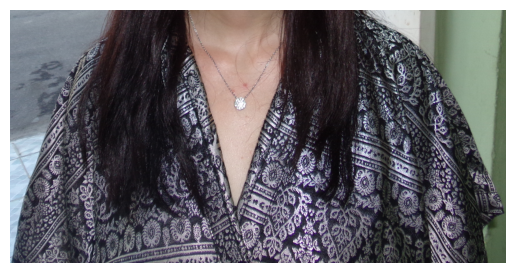

{'id': 0, 'path': '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/image_1727862019_qu73cq.png', 'id_usagetype': 'Ethnic', 'id_gender': 'Unisex', 'id_color': 'Silver', 'id_season': 'Winter', 'id_articletype': 'Robe'}


In [14]:
for image_path in new_image:
    print('Extracting the categories from the cropped image ...')
    # Perform CLIP evaluation to get the best matching category for each attribute
    gender = clip_evaluation(list(dict_genders.keys()),image_path)
    season = clip_evaluation(list(dict_seasons.keys()),image_path)
    color = clip_evaluation(list(dict_colors.keys()),image_path)
    usage = clip_evaluation(list(dict_usage.keys()),image_path)
    article = clip_evaluation(list(dict_article.keys()),image_path)

    with open(image_path, 'rb') as path:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axis
        plt.show()

    # Create a JSON object to send to the API
    json_post_image = {"id":0,
                        "path":image_path, 
                        "id_usagetype":usage,
                        "id_gender":gender,
                        "id_color":color,
                        "id_season":season,
                        "id_articletype":article}

    print(json_post_image)